<a href="https://colab.research.google.com/github/divyam123-EECS-Physics/NetLoadForecastingScripts/blob/pytorch1/Texas_PyTorch2_Pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
!pip install solarforecastarbiter
!pip install TimezoneFinder

import numpy as np
import matplotlib.pyplot as plt
from timezonefinder import TimezoneFinder
import solarforecastarbiter.metrics
from solarforecastarbiter.metrics.probabilistic import continuous_ranked_probability_score
import solarforecastarbiter.reference_forecasts
from solarforecastarbiter.reference_forecasts.persistence import persistence_probabilistic_timeofday

# from gluonts.mx.model.deep_npts import DeepNPTSEstimator
import torch
import scipy as sp

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split


In [ ]:

training_data = pd.read_csv('/content/drive/MyDrive/net_load_forecasting/training_datasets/texas_historical.csv')
test_data = pd.read_csv('/content/drive/MyDrive/net_load_forecasting/test_datasets/texas_2023-06-30_test.csv')

# Feature engineering


In [ ]:
training_data.rename(columns = {'Unnamed: 0':'time'}, inplace = True)
test_data.rename(columns = {'Unnamed: 0':'time'}, inplace = True)

training_data.drop(columns = 'quality_flag', inplace = True)
test_data.drop(columns = 'quality_flag', inplace = True)

In [ ]:
test_data

,time,value,temperature_2m,relativehumidity_2m,dewpoint_2m,apparent_temperature,precipitation,cloudcover,cloudcover_low,cloudcover_mid,cloudcover_high,shortwave_radiation,direct_radiation,diffuse_radiation,direct_normal_irradiance,sunset,sunrise
0,2023-06-01 01:00:00,0.405947,23.0,84,20.2,25.1,0.0,27,27,0,0,0.0,0.0,0.0,0.0,2023-06-01T20:30,2023-06-01T06:33
1,2023-06-01 02:00:00,0.358691,22.5,84,19.7,25.2,0.0,1,1,0,0,0.0,0.0,0.0,0.0,2023-06-01T20:30,2023-06-01T06:33
2,2023-06-01 03:00:00,0.335408,22.0,85,19.4,24.6,0.0,100,100,0,0,0.0,0.0,0.0,0.0,2023-06-01T20:30,2023-06-01T06:33
3,2023-06-01 04:00:00,0.341229,21.9,86,19.4,24.4,0.0,80,80,0,0,0.0,0.0,0.0,0.0,2023-06-01T20:30,2023-06-01T06:33
4,2023-06-01 05:00:00,0.379495,22.1,90,20.3,24.9,0.0,99,99,0,0,0.0,0.0,0.0,0.0,2023-06-01T20:30,2023-06-01T06:33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
786,2023-07-03 19:00:00,NaN,36.4,28,15.0,35.5,0.0,100,75,35,100,281.0,164.0,117.0,372.7,2023-07-03T20:39,2023-07-03T06:37
787,2023-07-03 20:00:00,NaN,34.9,31,15.2,34.7,0.0,100,0,79,100,142.0,80.0,62.0,386.7,2023-07-03T20:39,2023-07-03T06:37
788,2023-07-03 21:00:00,NaN,31.7,43,17.6,30.6,0.0,100,0,100,89,13.0,6.0,7.0,114.3,2023-07-03T20:39,2023-07-03T06:37
789,2023-07-03 22:00:00,NaN,29.3,54,19.0,29.7,0.0,80,0,78,66,0.0,0.0,0.0,0.0,2023-07-03T20:39,2023-07-03T06:37


In [ ]:
training_data.time = pd.to_datetime(training_data.time)
test_data.time = pd.to_datetime(test_data.time)

In [ ]:
test_data

,time,value,temperature_2m,relativehumidity_2m,dewpoint_2m,apparent_temperature,precipitation,cloudcover,cloudcover_low,cloudcover_mid,cloudcover_high,shortwave_radiation,direct_radiation,diffuse_radiation,direct_normal_irradiance,sunset,sunrise
0,2023-06-01 01:00:00,0.405947,23.0,84,20.2,25.1,0.0,27,27,0,0,0.0,0.0,0.0,0.0,2023-06-01T20:30,2023-06-01T06:33
1,2023-06-01 02:00:00,0.358691,22.5,84,19.7,25.2,0.0,1,1,0,0,0.0,0.0,0.0,0.0,2023-06-01T20:30,2023-06-01T06:33
2,2023-06-01 03:00:00,0.335408,22.0,85,19.4,24.6,0.0,100,100,0,0,0.0,0.0,0.0,0.0,2023-06-01T20:30,2023-06-01T06:33
3,2023-06-01 04:00:00,0.341229,21.9,86,19.4,24.4,0.0,80,80,0,0,0.0,0.0,0.0,0.0,2023-06-01T20:30,2023-06-01T06:33
4,2023-06-01 05:00:00,0.379495,22.1,90,20.3,24.9,0.0,99,99,0,0,0.0,0.0,0.0,0.0,2023-06-01T20:30,2023-06-01T06:33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
786,2023-07-03 19:00:00,NaN,36.4,28,15.0,35.5,0.0,100,75,35,100,281.0,164.0,117.0,372.7,2023-07-03T20:39,2023-07-03T06:37
787,2023-07-03 20:00:00,NaN,34.9,31,15.2,34.7,0.0,100,0,79,100,142.0,80.0,62.0,386.7,2023-07-03T20:39,2023-07-03T06:37
788,2023-07-03 21:00:00,NaN,31.7,43,17.6,30.6,0.0,100,0,100,89,13.0,6.0,7.0,114.3,2023-07-03T20:39,2023-07-03T06:37
789,2023-07-03 22:00:00,NaN,29.3,54,19.0,29.7,0.0,80,0,78,66,0.0,0.0,0.0,0.0,2023-07-03T20:39,2023-07-03T06:37


In [ ]:
training_data['hours'] = (training_data.time.dt.hour - 12) / 24
test_data['hours'] = (test_data.time.dt.hour - 12) / 24

In [ ]:
test_data

,time,value,temperature_2m,relativehumidity_2m,dewpoint_2m,apparent_temperature,precipitation,cloudcover,cloudcover_low,cloudcover_mid,cloudcover_high,shortwave_radiation,direct_radiation,diffuse_radiation,direct_normal_irradiance,sunset,sunrise,hours
0,2023-06-01 01:00:00,0.405947,23.0,84,20.2,25.1,0.0,27,27,0,0,0.0,0.0,0.0,0.0,2023-06-01T20:30,2023-06-01T06:33,-0.458333
1,2023-06-01 02:00:00,0.358691,22.5,84,19.7,25.2,0.0,1,1,0,0,0.0,0.0,0.0,0.0,2023-06-01T20:30,2023-06-01T06:33,-0.416667
2,2023-06-01 03:00:00,0.335408,22.0,85,19.4,24.6,0.0,100,100,0,0,0.0,0.0,0.0,0.0,2023-06-01T20:30,2023-06-01T06:33,-0.375000
3,2023-06-01 04:00:00,0.341229,21.9,86,19.4,24.4,0.0,80,80,0,0,0.0,0.0,0.0,0.0,2023-06-01T20:30,2023-06-01T06:33,-0.333333
4,2023-06-01 05:00:00,0.379495,22.1,90,20.3,24.9,0.0,99,99,0,0,0.0,0.0,0.0,0.0,2023-06-01T20:30,2023-06-01T06:33,-0.291667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
786,2023-07-03 19:00:00,NaN,36.4,28,15.0,35.5,0.0,100,75,35,100,281.0,164.0,117.0,372.7,2023-07-03T20:39,2023-07-03T06:37,0.291667
787,2023-07-03 20:00:00,NaN,34.9,31,15.2,34.7,0.0,100,0,79,100,142.0,80.0,62.0,386.7,2023-07-03T20:39,2023-07-03T06:37,0.333333
788,2023-07-03 21:00:00,NaN,31.7,43,17.6,30.6,0.0,100,0,100,89,13.0,6.0,7.0,114.3,2023-07-03T20:39,2023-07-03T06:37,0.375000
789,2023-07-03 22:00:00,NaN,29.3,54,19.0,29.7,0.0,80,0,78,66,0.0,0.0,0.0,0.0,2023-07-03T20:39,2023-07-03T06:37,0.416667


In [ ]:
test_data['sunrise'] = pd.to_datetime(test_data.sunrise)
test_data['sunset'] = pd.to_datetime(test_data.sunset)

test_data.sunrise = ((test_data.sunrise.dt.hour - 12) / 24) + ((test_data.sunrise.dt.minute - 30) / 60)
test_data.sunset = ((test_data.sunset.dt.hour - 12) / 24) + ((test_data.sunset.dt.minute - 30) / 60)

In [ ]:
test_data

,time,value,temperature_2m,relativehumidity_2m,dewpoint_2m,apparent_temperature,precipitation,cloudcover,cloudcover_low,cloudcover_mid,cloudcover_high,shortwave_radiation,direct_radiation,diffuse_radiation,direct_normal_irradiance,sunset,sunrise,hours
0,2023-06-01 01:00:00,0.405947,23.0,84,20.2,25.1,0.0,27,27,0,0,0.0,0.0,0.0,0.0,0.333333,-0.200000,-0.458333
1,2023-06-01 02:00:00,0.358691,22.5,84,19.7,25.2,0.0,1,1,0,0,0.0,0.0,0.0,0.0,0.333333,-0.200000,-0.416667
2,2023-06-01 03:00:00,0.335408,22.0,85,19.4,24.6,0.0,100,100,0,0,0.0,0.0,0.0,0.0,0.333333,-0.200000,-0.375000
3,2023-06-01 04:00:00,0.341229,21.9,86,19.4,24.4,0.0,80,80,0,0,0.0,0.0,0.0,0.0,0.333333,-0.200000,-0.333333
4,2023-06-01 05:00:00,0.379495,22.1,90,20.3,24.9,0.0,99,99,0,0,0.0,0.0,0.0,0.0,0.333333,-0.200000,-0.291667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
786,2023-07-03 19:00:00,NaN,36.4,28,15.0,35.5,0.0,100,75,35,100,281.0,164.0,117.0,372.7,0.483333,-0.133333,0.291667
787,2023-07-03 20:00:00,NaN,34.9,31,15.2,34.7,0.0,100,0,79,100,142.0,80.0,62.0,386.7,0.483333,-0.133333,0.333333
788,2023-07-03 21:00:00,NaN,31.7,43,17.6,30.6,0.0,100,0,100,89,13.0,6.0,7.0,114.3,0.483333,-0.133333,0.375000
789,2023-07-03 22:00:00,NaN,29.3,54,19.0,29.7,0.0,80,0,78,66,0.0,0.0,0.0,0.0,0.483333,-0.133333,0.416667


In [ ]:
training_data['sunrise'] = pd.to_datetime(training_data.sunrise)
training_data['sunset'] = pd.to_datetime(training_data.sunset)

training_data.sunrise = ((training_data.sunrise.dt.hour - 12) / 24) + ((training_data.sunrise.dt.minute - 30) / 60)
training_data.sunset = ((training_data.sunset.dt.hour - 12) / 24) + ((training_data.sunset.dt.minute - 30) / 60)

In [ ]:
training_data['month'] = training_data.time.dt.month
test_data['month'] = test_data.time.dt.month

In [ ]:
# test_data[test_data.value.isna()]

In [ ]:
lookback_start = 5
lookback_end = 8
lookback_dim = lookback_end - lookback_start + 1

for i in range(lookback_start, lookback_end + 1):
  training_data['prev_{}'.format(i)] = training_data.shift(i * 24).value
  test_data['prev_{}'.format(i)] = test_data.shift(i * 24).value



In [ ]:
test_data

,time,value,temperature_2m,relativehumidity_2m,dewpoint_2m,apparent_temperature,precipitation,cloudcover,cloudcover_low,cloudcover_mid,...,diffuse_radiation,direct_normal_irradiance,sunset,sunrise,hours,month,prev_5,prev_6,prev_7,prev_8
0,2023-06-01 01:00:00,0.405947,23.0,84,20.2,25.1,0.0,27,27,0,...,0.0,0.0,0.333333,-0.200000,-0.458333,6,NaN,NaN,NaN,NaN
1,2023-06-01 02:00:00,0.358691,22.5,84,19.7,25.2,0.0,1,1,0,...,0.0,0.0,0.333333,-0.200000,-0.416667,6,NaN,NaN,NaN,NaN
2,2023-06-01 03:00:00,0.335408,22.0,85,19.4,24.6,0.0,100,100,0,...,0.0,0.0,0.333333,-0.200000,-0.375000,6,NaN,NaN,NaN,NaN
3,2023-06-01 04:00:00,0.341229,21.9,86,19.4,24.4,0.0,80,80,0,...,0.0,0.0,0.333333,-0.200000,-0.333333,6,NaN,NaN,NaN,NaN
4,2023-06-01 05:00:00,0.379495,22.1,90,20.3,24.9,0.0,99,99,0,...,0.0,0.0,0.333333,-0.200000,-0.291667,6,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
786,2023-07-03 19:00:00,NaN,36.4,28,15.0,35.5,0.0,100,75,35,...,117.0,372.7,0.483333,-0.133333,0.291667,7,NaN,0.891079,0.928308,0.919951
787,2023-07-03 20:00:00,NaN,34.9,31,15.2,34.7,0.0,100,0,79,...,62.0,386.7,0.483333,-0.133333,0.333333,7,NaN,0.882722,0.907619,0.896611
788,2023-07-03 21:00:00,NaN,31.7,43,17.6,30.6,0.0,100,0,100,...,7.0,114.3,0.483333,-0.133333,0.375000,7,NaN,0.866125,0.873617,0.877536
789,2023-07-03 22:00:00,NaN,29.3,54,19.0,29.7,0.0,80,0,78,...,0.0,0.0,0.483333,-0.133333,0.416667,7,NaN,0.823651,0.834371,0.835581


In [ ]:
training_data.columns

Index(['time', 'value', 'temperature_2m', 'relativehumidity_2m', 'dewpoint_2m',
       'apparent_temperature', 'precipitation', 'cloudcover', 'cloudcover_low',
       'cloudcover_mid', 'cloudcover_high', 'shortwave_radiation',
       'direct_radiation', 'diffuse_radiation', 'direct_normal_irradiance',
       'sunset', 'sunrise', 'hours', 'month', 'prev_5', 'prev_6', 'prev_7',
       'prev_8'],
      dtype='object')

In [ ]:
training_data = training_data[(training_data.prev_8.isna() == False)].reset_index().drop(columns = 'index')

In [ ]:
training_data

,time,value,temperature_2m,relativehumidity_2m,dewpoint_2m,apparent_temperature,precipitation,cloudcover,cloudcover_low,cloudcover_mid,...,diffuse_radiation,direct_normal_irradiance,sunset,sunrise,hours,month,prev_5,prev_6,prev_7,prev_8
0,2022-01-09 01:00:00,0.298006,11.5,96,10.9,10.6,0.0,66,73,0,...,0.0,0.0,0.650000,-0.2,-0.458333,1,0.363935,0.402086,0.310281,0.420758
1,2022-01-09 02:00:00,0.286019,10.7,99,10.6,10.0,0.0,63,70,0,...,0.0,0.0,0.650000,-0.2,-0.416667,1,0.356213,0.406178,0.292819,0.392404
2,2022-01-09 03:00:00,0.278008,10.0,99,9.9,9.0,0.0,90,100,0,...,0.0,0.0,0.650000,-0.2,-0.375000,1,0.359440,0.403124,0.286249,0.379380
3,2022-01-09 04:00:00,0.288382,9.6,100,9.6,8.3,0.0,90,100,0,...,0.0,0.0,0.650000,-0.2,-0.333333,1,0.360592,0.416321,0.286077,0.356155
4,2022-01-09 05:00:00,0.274205,9.5,100,9.5,8.9,0.0,90,100,0,...,0.0,0.0,0.650000,-0.2,-0.291667,1,0.373329,0.432284,0.290975,0.339557
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12148,2023-05-30 07:00:00,0.306132,19.1,96,18.4,21.8,0.0,0,0,0,...,4.0,0.0,0.316667,-0.2,-0.208333,5,0.381051,0.373559,0.385892,0.347914
12149,2023-05-30 08:00:00,0.306478,21.1,92,19.8,24.3,0.0,0,0,0,...,46.0,194.6,0.316667,-0.2,-0.166667,5,0.372291,0.352178,0.366471,0.340018
12150,2023-05-30 09:00:00,0.300599,23.4,81,19.9,26.8,0.0,0,0,0,...,85.0,479.4,0.316667,-0.2,-0.125000,5,0.361342,0.355406,0.350046,0.337079
12151,2023-05-30 10:00:00,0.344456,25.0,72,19.7,28.4,0.0,0,0,0,...,102.0,649.7,0.316667,-0.2,-0.083333,5,0.363013,0.370562,0.376671,0.325092


In [ ]:
# new_df = training_data.drop(columns = 'time')
new_df = training_data[(training_data['time'] <= '2022-10-01 00:00:00') | (training_data['time'] >= '2023-04-14 00:00:00')].drop(columns = 'time')


In [ ]:


val_df = test_data[(test_data.value.isna() == False) &
                   (test_data.prev_8.isna() == False)].drop(columns = 'time')
test_df_new = test_data[test_data.value.isna() == True][-24-23:-23].reset_index().drop(columns = ['index','time'])

In [ ]:
test_data[(test_data.value.isna() == False) & (test_data.prev_8.isna() == False)]

,time,value,temperature_2m,relativehumidity_2m,dewpoint_2m,apparent_temperature,precipitation,cloudcover,cloudcover_low,cloudcover_mid,...,diffuse_radiation,direct_normal_irradiance,sunset,sunrise,hours,month,prev_5,prev_6,prev_7,prev_8
192,2023-06-09 01:00:00,0.454933,24.8,80,21.1,28.6,0.0,0,0,0,...,0.0,0.0,0.400000,-0.216667,-0.458333,6,0.396900,0.373963,0.417128,0.405947
193,2023-06-09 02:00:00,0.405256,24.3,82,21.0,28.3,0.0,0,0,0,...,0.0,0.0,0.400000,-0.216667,-0.416667,6,0.374366,0.344283,0.383875,0.358691
194,2023-06-09 03:00:00,0.362379,23.6,82,20.3,27.3,0.0,0,0,0,...,0.0,0.0,0.400000,-0.216667,-0.375000,6,0.347165,0.309763,0.351199,0.335408
195,2023-06-09 04:00:00,0.338405,23.7,78,19.6,27.1,0.0,0,0,0,...,0.0,0.0,0.400000,-0.216667,-0.333333,6,0.321980,0.277317,0.335177,0.341229
196,2023-06-09 05:00:00,0.342958,23.5,81,20.0,26.9,0.0,0,0,0,...,0.0,0.0,0.400000,-0.216667,-0.291667,6,0.313163,0.264408,0.386353,0.379495
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
652,2023-06-28 05:00:00,0.423755,24.4,85,21.7,28.1,0.0,84,84,0,...,0.0,0.0,0.466667,-0.166667,-0.291667,6,0.392174,0.410270,0.442312,0.442773
653,2023-06-28 06:00:00,0.435512,24.5,89,22.5,28.7,0.0,8,8,0,...,0.0,0.0,0.466667,-0.166667,-0.250000,6,0.393557,0.420067,0.448536,0.476314
654,2023-06-28 07:00:00,0.428596,24.4,91,22.8,28.8,0.0,6,6,0,...,22.0,6.0,0.466667,-0.166667,-0.208333,6,0.414477,0.406293,0.460120,0.484843
655,2023-06-28 08:00:00,0.415111,24.9,90,23.1,29.2,0.0,8,8,0,...,60.0,631.7,0.466667,-0.166667,-0.166667,6,0.402432,0.426810,0.457065,0.475622


In [ ]:
val_df=val_df[new_df.columns]
test_df_new=test_df_new[new_df.columns]

# Train Val Split

In [ ]:
X_train = new_df[[col for col in new_df.columns if col != 'value']]
y_train = new_df.value
X_train = torch.from_numpy(X_train.values).to(torch.float64)
y_train = torch.from_numpy(y_train.values).to(torch.float64)


In [ ]:
X_val = val_df[[col for col in val_df.columns if col != 'value']]
y_val = val_df.value
X_val = torch.from_numpy(X_val.values).to(torch.float64)
y_val = torch.from_numpy(y_val.values).to(torch.float64)

# Defining models

In [ ]:
class TrendsModel(nn.Module):
  def __init__(self, input_dim, hidden_dim, output_dim):
    super(TrendsModel, self).__init__()
    self.fc1 = nn.Linear(input_dim, hidden_dim).to(torch.float64)
    # self.fc2 = nn.Linear(hidden_dim, 1).to(torch.float64)
    self.fc2 = nn.Linear(hidden_dim, hidden_dim).to(torch.float64)
    # self.fc3 = nn.Linear(hidden_dim, hidden_dim).to(torch.float64)
    # self.fc4 = nn.Linear(hidden_dim, hidden_dim).to(torch.float64)
    # self.fc5 = nn.Linear(hidden_dim, hidden_dim).to(torch.float64)
    # self.fc6 = nn.Linear(hidden_dim, hidden_dim).to(torch.float64)
    # self.fc7 = nn.Linear(hidden_dim, 1).to(torch.float64)
    self.relu = nn.ReLU().to(torch.float64)
    # self.softplus = nn.Softplus().to(torch.float64)
    self.softmax = nn.Softmax().to(torch.float64)
  def forward(self, x):
    x = self.fc1(x)
    x = self.relu(x)
    x = self.fc2(x)
    # x = self.relu(x)
    # x = self.fc3(x)
    # x = self.relu(x)
    # x = self.fc4(x)
    # x = self.relu(x)
    # x = self.fc5(x)
    # x = self.relu(x)
    # x = self.fc6(x)
    # x = self.relu(x)
    # x = self.fc7(x)
    return x

class FeaturesModel(nn.Module):
    def __init__(self, input_dim, hidden_dim,output_dim):
        super(FeaturesModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim).to(torch.float64)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim).to(torch.float64)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim).to(torch.float64)
        self.fc4 = nn.Linear(hidden_dim, hidden_dim).to(torch.float64)
        self.fc5 = nn.Linear(hidden_dim, hidden_dim).to(torch.float64)
        self.fc6 = nn.Linear(hidden_dim, hidden_dim).to(torch.float64)
        # self.fc7 = nn.Linear(hidden_dim, 1).to(torch.float64)
        self.fc7 = nn.Linear(hidden_dim, hidden_dim).to(torch.float64)
        self.relu = nn.ReLU().to(torch.float64)
        # self.softplus = nn.Softplus().to(torch.float64)
        self.softmax = nn.Softmax().to(torch.float64)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.relu(x)
        x = self.fc4(x)
        x = self.relu(x)
        x = self.fc5(x)
        x = self.relu(x)
        x = self.fc6(x)
        x = self.relu(x)
        x = self.fc7(x)
        return x

class Trend_Feature_model(nn.Module):
  def __init__(self, feature_dim, feature_hidden, lookback_dim, hidden_dim, output_dim, trend_weight = 0.4):
    super(Trend_Feature_model, self).__init__()
    self.trends_model = TrendsModel(lookback_dim, hidden_dim, output_dim)
    self.features_model = FeaturesModel(feature_dim, feature_hidden, output_dim)
    self.combining_layer = nn.Linear(feature_hidden + hidden_dim, hidden_dim).to(torch.float64)
    self.output_layer = nn.Linear(hidden_dim, 1).to(torch.float64)
    self.trend_weight = trend_weight
    self.lookback_dim = lookback_dim
    self.hidden_dim = hidden_dim
  def forward(self, x):
    x_features = x[:,:-1 * self.lookback_dim]
    x_lookback = x[:,-1 * self.lookback_dim:]
    std_hour = x[:,-self.lookback_dim:].std(dim = 1).view(-1,1)

    feature_output = self.features_model(x_features)
    trends_output = self.trends_model(x_lookback)
    # x = (feature_output * (1 - self.trend_weight)) + (trends_output * self.trend_weight)
    x = torch.concat([feature_output,trends_output], axis = 1).to(torch.float64)
    # print(x.shape, self.hidden_dim)
    x = self.combining_layer(x)
    x = self.output_layer(x)
    return x



# Loss Functions

In [ ]:
def crps_loss(y_pred, y_obs):
    n = len(y_pred)
    fx = y_pred
    fx_prob = torch.tensor([i for i in range(0,110,10)]).unsqueeze(0).repeat(y_pred.shape[0],1)
    # extend CDF min to ensure obs within forecast support
    # fx.shape = (n, d) ==> (n, d + 1)
    fx_min = torch.minimum(y_obs, y_pred[:, 0])
    y_pred = torch.hstack([fx_min[:, None], y_pred])
    fx_prob = torch.hstack([torch.zeros([n, 1]), fx_prob])

    # extend CDF max to ensure obs within forecast support
    # fx.shape = (n, d + 1) ==> (n, d + 2)
    idx = (fx[:, -1] < y_obs)
    fx_max = torch.maximum(y_obs, y_pred[:, -1])
    y_pred = torch.hstack([y_pred, fx_max[:, None]])
    fx_prob = torch.hstack([fx_prob, torch.full([n, 1], 100)])

    # indicator function:
    # - left of the obs is 0.0
    # - obs and right of the obs is 1.0
    o = torch.where(y_pred >= y_obs[:, None], 1.0, 0.0)

    # correct behavior when obs > max fx:
    # - should be 0 over range: max fx < x < obs
    o[idx, -1] = 0.0

    # forecast probabilities [unitless]
    f = fx_prob / 100.0
    # integrate along each sample, then average all samples
    crps = torch.mean(torch.trapezoid((f - o) ** 2, x=y_pred, axis=1))
    return crps# + torch.abs(((y_pred[:,5] - y_obs)) ** 2).mean()


def negLL(y_pred, y_true):
    mu = y_pred[:,0]
    # print("y_pred.shape",y_pred.shape,"y_true.shape",y_true.shape)
    # sigma = y_pred[:,1]
    # denom = torch.sqrt(1/(2 * 2 * torch.pi))
    loss = (((mu - y_true)/ 2) ** 2) #- torch.log(denom)
    return loss.mean()

def negLL2(y_pred, y_true):
    # mu = y_pred[:,0]
    num_quantiles = 11
    obs =  y_true.unsqueeze(1).repeat(1,num_quantiles)
    # sigma = y_pred[:,1]
    # denom = torch.sqrt(1/(2 * 2 * torch.pi))
    loss = (((y_pred - obs)/ 2) ** 2) #- torch.log(denom)
    return loss.mean()

def mae(y_pred, y_true):
    mu = y_pred[:,0]
    # sigma = y_pred[:,1]
    # denom = torch.sqrt(1/(2 * 2 * torch.pi))
    loss = torch.abs(((mu - y_true))) #- torch.log(denom)
    return loss.mean()

def mae2(y_pred, y_true):
    # mu = y_pred[:,0]
    num_quantiles = 11
    obs =  y_true.unsqueeze(1).repeat(1,num_quantiles)
    # sigma = y_pred[:,1]
    # denom = torch.sqrt(1/(2 * 2 * torch.pi))
    loss = torch.abs(((y_pred - obs)/ 2)) #- torch.log(denom)
    return loss.mean()

#Dataloader

In [ ]:

class CDataset(Dataset):
    def __init__(self, X, y):
        self.X = X#.values
        self.y = y#.values

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = self.X[idx]
        y = self.y[idx]
        return x, y

# Training Loop

In [ ]:
# from torch._C import float64
# Define the custom data loaders
batch_size = 64
train_dataset = CDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataset = CDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Initialize the model
feature_dim = X_train.shape[1] - lookback_dim#22  # Specify the input feature dimensions
feature_hidden = 16
lookback_dim = lookback_dim
lookback_hidden = lookback_dim - 2

model = Trend_Feature_model(feature_dim = feature_dim, feature_hidden = int(feature_dim * 0.8),
                            lookback_dim=lookback_dim,
                            hidden_dim = lookback_hidden,
                            output_dim = 1,
                            trend_weight=0.9)
# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer

# Training loop
num_epochs = 150  # Specify the number of training epochs
train_losses = []
val_losses = []

for epoch in range(num_epochs):

    model.eval()  # Set the model to evaluation mode
    val_loss = 0

    with torch.no_grad():
        for batch_X, batch_y in val_loader:

            outputs = model(batch_X)
            loss = negLL(outputs, batch_y)
            # loss = mae(outputs, batch_y)
            # loss = crps_loss(outputs, batch_y)
            val_loss += loss.item()

    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    model.train()  # Set the model to training mode
    i = 0
    train_loss = 0


    for batch_X, batch_y in train_loader:#range(3):
        # Forward pass
        outputs = model(batch_X)
        loss = negLL(outputs, batch_y)
        i += 1
        train_loss += loss.item()
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_losses.append(train_loss/i)
    # Validation loop

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss.item()}, Val Loss: {val_loss}')


Epoch [1/150], Train Loss: 0.006038794392213374, Val Loss: 0.12416724641579564
Epoch [2/150], Train Loss: 0.0023967619741938674, Val Loss: 0.006461062689481974
Epoch [3/150], Train Loss: 0.0016212796740129154, Val Loss: 0.002494779965610837
Epoch [4/150], Train Loss: 0.001389301553768515, Val Loss: 0.001273472974282696
Epoch [5/150], Train Loss: 0.0006361928069383092, Val Loss: 0.0013424167284695598
Epoch [6/150], Train Loss: 0.0010723111950047802, Val Loss: 0.0008239879410769835
Epoch [7/150], Train Loss: 0.001177076769199936, Val Loss: 0.0014337957477813575
Epoch [8/150], Train Loss: 0.0004871762519609633, Val Loss: 0.001013025489360438
Epoch [9/150], Train Loss: 0.0012187066356890471, Val Loss: 0.0011811957768907565
Epoch [10/150], Train Loss: 0.0007907845673811118, Val Loss: 0.0010646507365878266
Epoch [11/150], Train Loss: 0.0005702113208799146, Val Loss: 0.0007507473125038703
Epoch [12/150], Train Loss: 0.0007174196189563607, Val Loss: 0.001054813451247911
Epoch [13/150], Train L

In [ ]:
# test_data

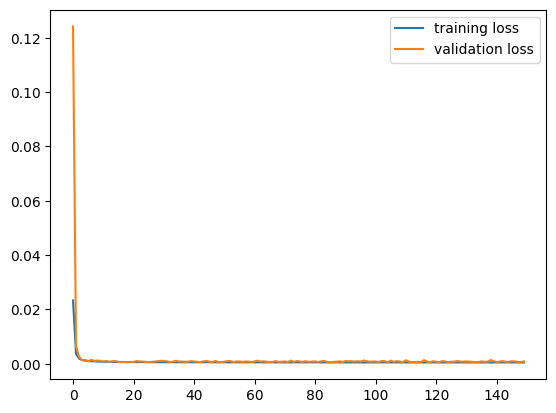

In [ ]:
plt.plot(train_losses, label = 'training loss')
plt.plot(val_losses, label = 'validation loss')
plt.legend()
plt.show()

# Inspection Space

In [ ]:
temp = test_data[(test_data.time >= '2023-06-22 01:00:00') & (test_data.time <= '2023-06-23 00:00:00')].drop(columns = 'time')


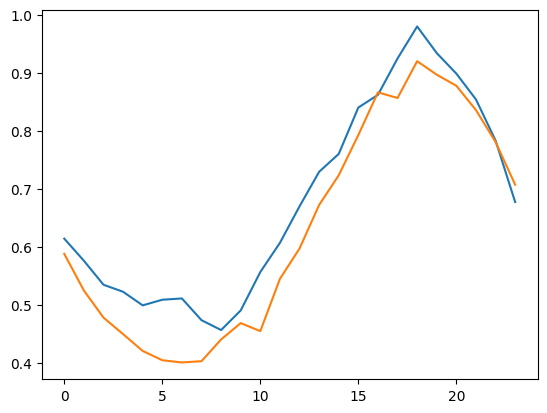

In [ ]:
temp = test_data[(test_data.time >= '2023-06-25 01:00:00') & (test_data.time <= '2023-06-26 00:00:00')].drop(columns = 'time')
X_train = temp[[col for col in temp.columns if col != 'value']]
y_train = temp.value
X_train = torch.from_numpy(X_train.values).to(torch.float64)
y_train = torch.from_numpy(y_train.values).to(torch.float64)


pred = model(X_train)

plt.plot(pred.detach().numpy())
plt.plot(y_train)

In [ ]:
test_data[test_data.value.isna() == False]

,time,value,temperature_2m,relativehumidity_2m,dewpoint_2m,apparent_temperature,precipitation,cloudcover,cloudcover_low,cloudcover_mid,...,diffuse_radiation,direct_normal_irradiance,sunset,sunrise,hours,month,prev_5,prev_6,prev_7,prev_8
0,2023-06-01 01:00:00,0.405947,23.0,84,20.2,25.1,0.0,27,27,0,...,0.0,0.0,0.333333,-0.200000,-0.458333,6,NaN,NaN,NaN,NaN
1,2023-06-01 02:00:00,0.358691,22.5,84,19.7,25.2,0.0,1,1,0,...,0.0,0.0,0.333333,-0.200000,-0.416667,6,NaN,NaN,NaN,NaN
2,2023-06-01 03:00:00,0.335408,22.0,85,19.4,24.6,0.0,100,100,0,...,0.0,0.0,0.333333,-0.200000,-0.375000,6,NaN,NaN,NaN,NaN
3,2023-06-01 04:00:00,0.341229,21.9,86,19.4,24.4,0.0,80,80,0,...,0.0,0.0,0.333333,-0.200000,-0.333333,6,NaN,NaN,NaN,NaN
4,2023-06-01 05:00:00,0.379495,22.1,90,20.3,24.9,0.0,99,99,0,...,0.0,0.0,0.333333,-0.200000,-0.291667,6,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
652,2023-06-28 05:00:00,0.423755,24.4,85,21.7,28.1,0.0,84,84,0,...,0.0,0.0,0.466667,-0.166667,-0.291667,6,0.392174,0.410270,0.442312,0.442773
653,2023-06-28 06:00:00,0.435512,24.5,89,22.5,28.7,0.0,8,8,0,...,0.0,0.0,0.466667,-0.166667,-0.250000,6,0.393557,0.420067,0.448536,0.476314
654,2023-06-28 07:00:00,0.428596,24.4,91,22.8,28.8,0.0,6,6,0,...,22.0,6.0,0.466667,-0.166667,-0.208333,6,0.414477,0.406293,0.460120,0.484843
655,2023-06-28 08:00:00,0.415111,24.9,90,23.1,29.2,0.0,8,8,0,...,60.0,631.7,0.466667,-0.166667,-0.166667,6,0.402432,0.426810,0.457065,0.475622


In [ ]:
import solarforecastarbiter.metrics
from solarforecastarbiter.metrics.probabilistic import continuous_ranked_probability_score

In [ ]:
weather_cols = ['dewpoint_2m','relativehumidity_2m','temperature_2m',
                'apparent_temperature', 'precipitation', 'cloudcover', 'cloudcover_low',
                'cloudcover_mid', 'cloudcover_high', 'shortwave_radiation',
                'direct_radiation', 'diffuse_radiation', 'direct_normal_irradiance']
weather_dictionary = {col:[] for col in weather_cols}

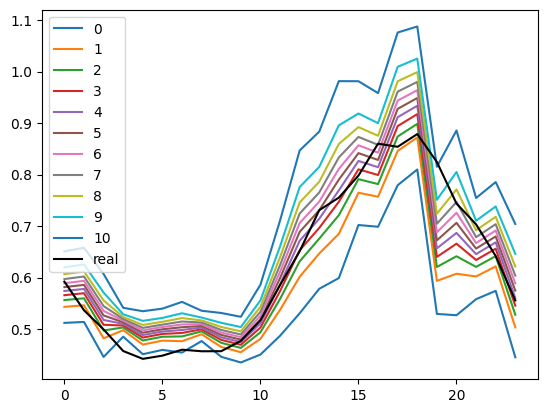

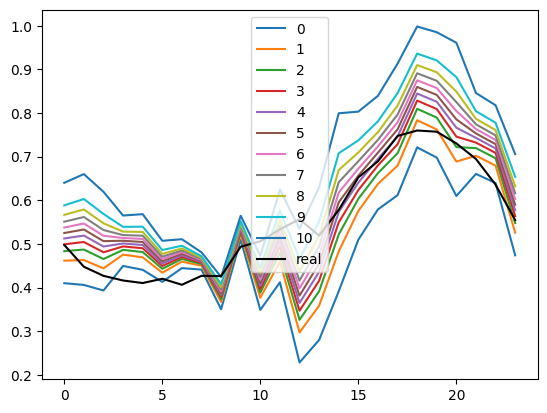

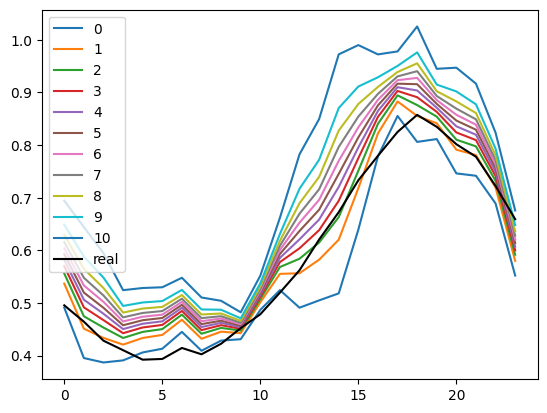

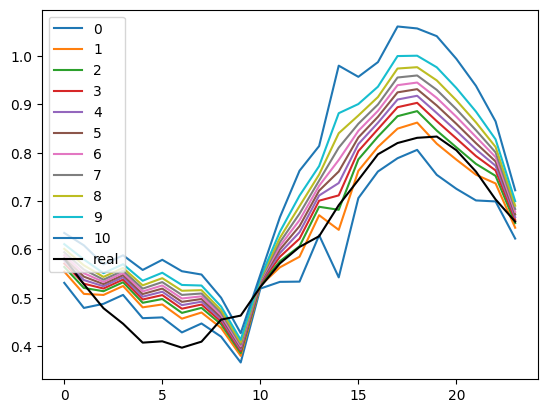

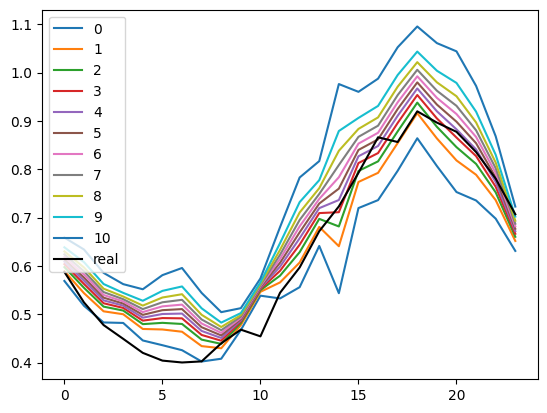

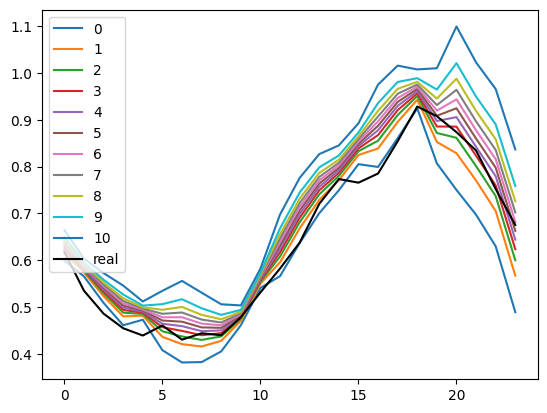

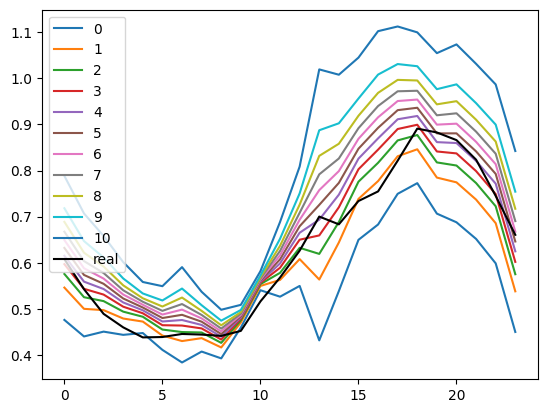

In [ ]:
daily_crps = []

for day in range(22, 29):
  test_df = test_data[(test_data.time >= '2023-06-{:02d} 01:00:00'.format(day - 1))
                    & (test_data.time <= '2023-06-{:02d} 00:00:00'.format(day))].drop(columns = 'time')

  X_test = test_df[[col for col in test_df.columns if col != 'value']]
  y_test = test_df.value
  X_test = torch.from_numpy(X_test.values).to(torch.float64)
  y_test = torch.from_numpy(y_test.values).to(torch.float64)

  preds = model(X_test)

  hourly_deviations = []
  meanies = []
  std_hour = X_test[:,-lookback_dim:].std(dim = 1).view(24,1)


  vals = []
  for i in range(0, 11):
    q = i/10 if i not in [0,10] else (0.01 if i == 0 else 0.99)

    pred2 = preds + (1.25 * std_hour) * torch.sqrt(torch.tensor(2)) * torch.erfinv(torch.tensor((2 * q) - 1))

    vals.append(pred2)
    plt.plot(pred2.detach().numpy(), label = str(i))

  plt.plot(y_test, color = 'black', label = 'real')
  plt.legend()
  plt.show()

  for col in weather_cols:
    weather_data = test_df[col].values
    weather_dictionary[col].append(test_df[col].std())


  pred = torch.concat(vals, dim = 1).detach().numpy()

  # submission = pd.DataFrame(columns = ['timestamp']+['p' + str(i*10) for i in range(11)])
  # submission['timestamp'] = pd.date_range(start = '2023-06-{0:2d} 01:00:00'.format(day - 1),
  #                                         end =  '2023-06-{0:2d} 00:00:00'.format(day),
  #                                         freq='H',
  #                                         tz = states['ga']['local_time_zone']
  #                                         )

  submission[['p' + str(i*10) for i in range(11)]] = pred

  obs = y_test.detach().numpy()
  fx = pred
  fx_prob = torch.tensor([i for i in range(0,110,10)]).unsqueeze(0).repeat(24,1).numpy()

  crps = continuous_ranked_probability_score(obs, fx, fx_prob)
  daily_crps.append(crps)
  # submission.to_csv("/content/drive/MyDrive/net_load_forecasting/submissions/_new_model_June_{:02d}.csv".format(day))

# plt.plot(,daily_crps)
# plt.show()

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2829: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2830: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


13 13


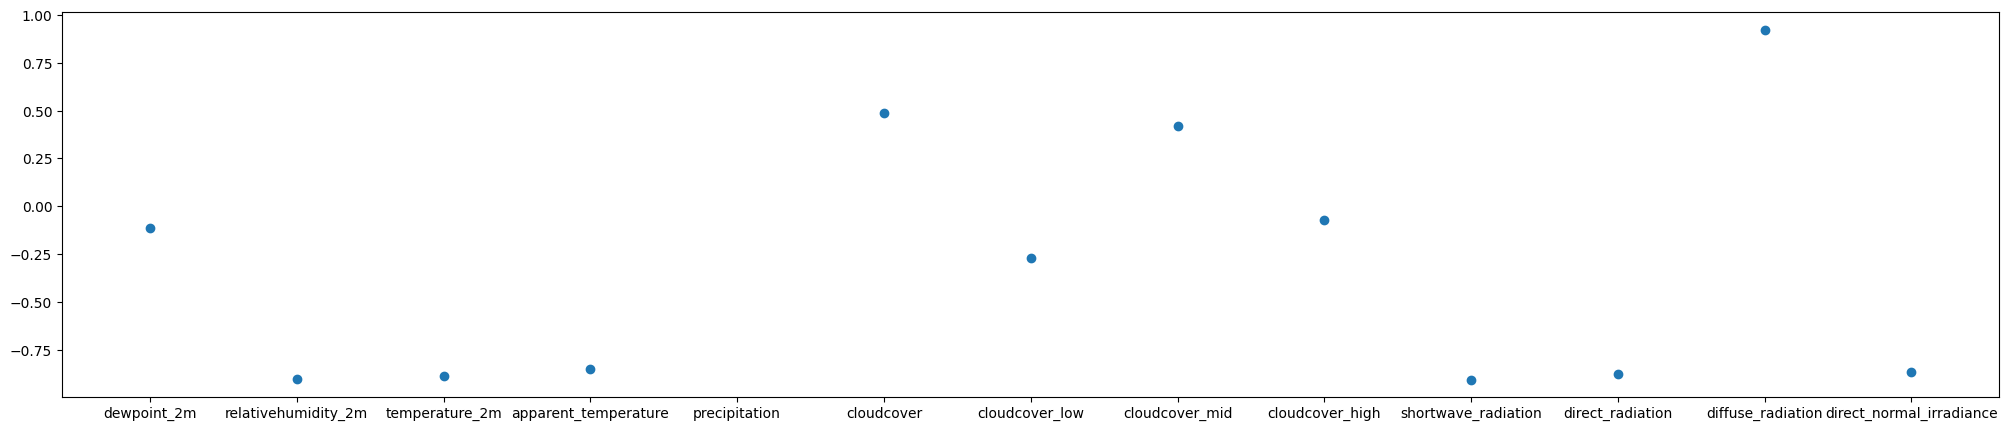

In [ ]:
# plt.plot(range(22,29),daily_crps, label = 'crps', color = 'black')
corrs = []
for col in weather_cols:
  corrs.append(np.corrcoef(daily_crps, weather_dictionary[col])[0][1])
print(len(corrs), len(weather_cols))
plt.figure(figsize = (25,5))
plt.scatter(weather_cols,corrs)
plt.show()

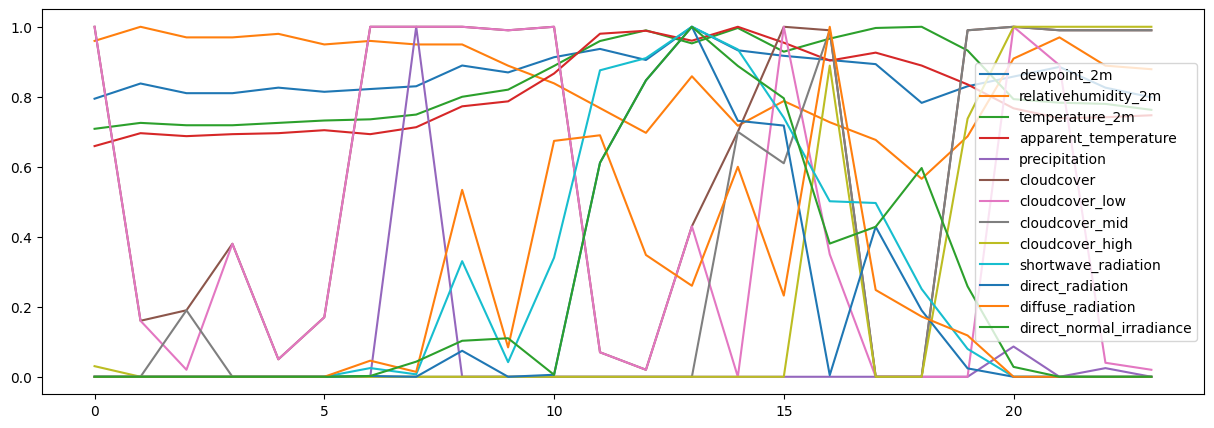

In [ ]:
day = 23
test_df = test_data[(test_data.time >= '2023-06-{:02d} 01:00:00'.format(day - 1)) & (test_data.time <= '2023-06-{:02d} 00:00:00'.format(day))].drop(columns = 'time')
plt.figure(figsize = (15,5))
for col in weather_cols:
  weather_data = test_df[col].values
  weather_dictionary[col].append(test_df[col].std())
  plt.plot(weather_data / np.max(np.abs(weather_data)), label = col)

plt.legend()
plt.show()

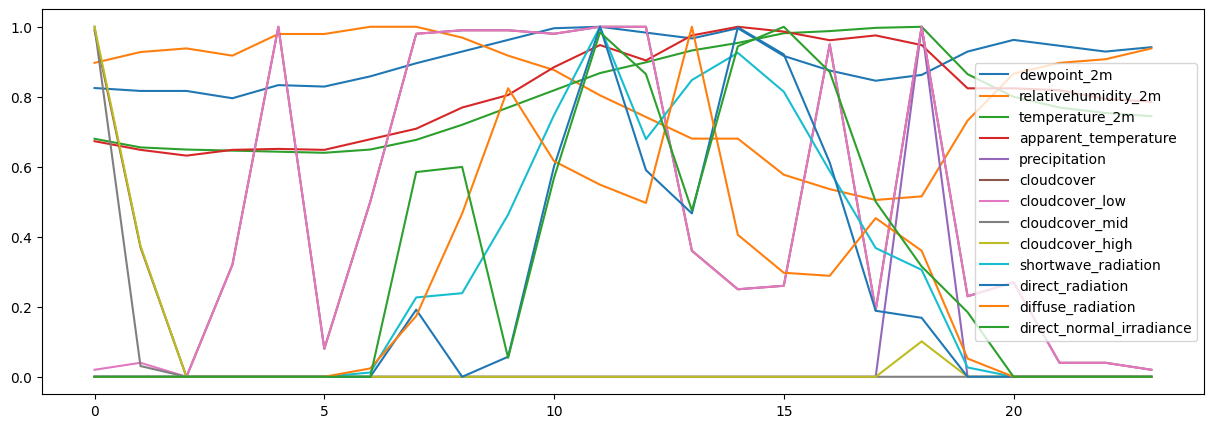

In [ ]:
day = 24
test_df = test_data[(test_data.time >= '2023-06-{:02d} 01:00:00'.format(day - 1)) & (test_data.time <= '2023-06-{:02d} 00:00:00'.format(day))].drop(columns = 'time')
plt.figure(figsize = (15,5))
for col in weather_cols:
  weather_data = test_df[col].values
  plt.plot(weather_data / np.max(np.abs(weather_data)), label = col)

plt.legend()
plt.show()

In [ ]:
# current_day = -1
# biases = []
# predictions = []
# observations = []
# for i in range(lookback_start, lookback_end + 1):
#   test_df = test_data[(-24 * (i) + 1):(-24 * (i) + 1) + 24].drop(columns = 'time')
#   X_test = test_df[[col for col in test_df.columns if col != 'value']]
#   y_test = test_df.value
#   X_test = torch.from_numpy(X_test.values).to(torch.float64)
#   y_test = torch.from_numpy(y_test.values).to(torch.float64)

#   preds = model(X_test)

#   predictions.append(preds)
#   observations.append(y_test)

# mean_pred = torch.zeros((24,1))
# mean_obs = torch.zeros((24,1))

# for i in range(lookback_dim):
#   mean_pred += predictions[i]
#   mean_obs += observations[i].view(24,1)

# mean_obs /= lookback_dim
# mean_pred /= lookback_dim

# test_df = test_data[-23-24:-23].drop(columns = 'time')
# X_test = test_df[[col for col in test_df.columns if col != 'value']]
# y_test = test_df.value
# X_test = torch.from_numpy(X_test.values).to(torch.float64)
# y_test = torch.from_numpy(y_test.values).to(torch.float64)

# preds = model(X_test)

# hourly_deviations = []
# meanies = []
# std_hour = X_test[:,-lookback_dim:].std(dim = 1).view(24,1)


# vals = []
# for i in range(0, 11):
#   q = i/10 if i not in [0,10] else (0.01 if i == 0 else 0.99)
#   bias = mean_pred - mean_obs
#   corrected_mean = preds - bias


#   pred2 = preds + std_hour * torch.sqrt(torch.tensor(2)) * torch.erfinv(torch.tensor((2 * q) - 1))

#   vals.append(pred2)
#   plt.plot(pred2.detach().numpy(), label = str(i))

# plt.legend()
# plt.show()

# pred = torch.concat(vals, dim = 1).detach().numpy()


# BIAS CORRECTION AND SUBMISSION

In [ ]:
from timezonefinder import TimezoneFinder
states = {
    'hi': {
        "lat":21.446911,
        "lon":-158.188736,
        "fresh_data_time":'12',
    },
    'or': {
        "lat":45.114559,
        "lon":-123.204903,
        "fresh_data_time":'12',
    },
    'tx': {
        "lat":29.424122,
        "lon":-98.493629,
        "fresh_data_time":'06',
    },
    'ga': {
        "lat":31.044241,
        "lon":-84.879128,
        "fresh_data_time":'06',
    },

}
tf = TimezoneFinder(in_memory=True)
for state in states:
  local_time_zone = tf.timezone_at(lng = states[state]['lon'], lat = states[state]['lat'])
  states[state]['local_time_zone'] = local_time_zone


tx_lon = -98.493629
tx_lat = 29.424122
ga_lon = -84.879128
ga_lat = 31.044241
or_lon = -123.204903
or_lat = 45.114559
hi_lat = 21.446911
hi_lon = -158.188736



from solarforecastarbiter.io import api
def upload_function(data_df, state = 'hi'):
    email = 'nlf2023-coral@forecastarbiter.com'
    pwd =  'T3&b@O*KiGf$a@!@3LBv'
    token = api.request_cli_access_token(email, pwd)
    session = api.APISession(token, base_url="https://api.forecastarbiter.com")
    if state == 'hi':

        hawaii_forecast_ids = [
           ["60534840-0044-11ee-8096-22bbbfba48a8", "p0"],
           ["60551d2e-0044-11ee-aea4-22bbbfba48a8", "p10"],
           ["60577a7c-0044-11ee-9d93-22bbbfba48a8", "p20"],
           ["6059b4ae-0044-11ee-b9f7-22bbbfba48a8", "p30"],
           ["605c7e09-0044-11ee-88c5-22bbbfba48a8", "p40"],
           ["605f5aad-0044-11ee-a68f-22bbbfba48a8", "p50"],
           ["6061a141-0044-11ee-b645-22bbbfba48a8", "p60"],
           ["6063f5d3-0044-11ee-a725-22bbbfba48a8", "p70"],
           ["606656a8-0044-11ee-aca6-22bbbfba48a8", "p80"],
           ["6069aa58-0044-11ee-b4a8-22bbbfba48a8", "p90"],
           ["606c387a-0044-11ee-92ea-22bbbfba48a8", "p100"],
        ]
        for uuid, col in hawaii_forecast_ids:
            upload_df = data_df[col]
            upload_df = upload_df.rename('value')
            session.post_probabilistic_forecast_constant_value_values(uuid, upload_df)

        return
    if state == 'tx':
        tx_forecast_ids = [
           ["51936f7f-0044-11ee-8006-22bbbfba48a8", "p0"],
           ["5195a4a9-0044-11ee-9abe-22bbbfba48a8", "p10"],
           ["5199b969-0044-11ee-8c5b-22bbbfba48a8", "p20"],
           ["519be6af-0044-11ee-aa1b-22bbbfba48a8", "p30"],
           ["519e4691-0044-11ee-ace3-22bbbfba48a8", "p40"],
           ["51a07836-0044-11ee-b70a-22bbbfba48a8", "p50"],
           ["51a2b229-0044-11ee-9369-22bbbfba48a8", "p60"],
           ["51a54811-0044-11ee-9b1c-22bbbfba48a8", "p70"],
           ["51a78587-0044-11ee-ac5f-22bbbfba48a8", "p80"],
           ["51a96889-0044-11ee-95de-22bbbfba48a8", "p90"],
           ["51ac716f-0044-11ee-96a0-22bbbfba48a8", "p100"],
        ]
        for uuid, col in tx_forecast_ids:
            upload_df = data_df[col]
            upload_df = upload_df.rename('value')
            session.post_probabilistic_forecast_constant_value_values(uuid, upload_df)

        return
    if state == 'or':

        or_forecast_ids = [
           ["58ea38ee-0044-11ee-abf9-aa678857fb1c", "p0"],
           ["58ecd0ac-0044-11ee-96ef-aa678857fb1c", "p10"],
           ["58efa6af-0044-11ee-a87e-aa678857fb1c", "p20"],
           ["58f2856f-0044-11ee-94d6-aa678857fb1c", "p30"],
           ["58f4d11c-0044-11ee-80ca-aa678857fb1c", "p40"],
           ["58f792d8-0044-11ee-869d-aa678857fb1c", "p50"],
           ["58fa355e-0044-11ee-881a-aa678857fb1c", "p60"],
           ["58fc98a1-0044-11ee-b2cb-aa678857fb1c", "p70"],
           ["58ff236c-0044-11ee-ba4c-aa678857fb1c", "p80"],
           ["5901b51f-0044-11ee-aae2-aa678857fb1c", "p90"],
           ["59045e2b-0044-11ee-8914-aa678857fb1c", "p100"],
        ]
        for uuid, col in or_forecast_ids:
            upload_df = data_df[col]
            upload_df = upload_df.rename('value')
            session.post_probabilistic_forecast_constant_value_values(uuid, upload_df)

        return
    if state == 'ga':

        ga_forecast_ids = [
           ["493ba331-0044-11ee-936c-aa678857fb1c", "p0"],
           ["493e3bce-0044-11ee-bdf4-aa678857fb1c", "p10"],
           ["4940a921-0044-11ee-8e27-aa678857fb1c", "p20"],
           ["49431d34-0044-11ee-a476-aa678857fb1c", "p30"],
           ["4945f80a-0044-11ee-8674-aa678857fb1c", "p40"],
           ["49489e6d-0044-11ee-8ce3-aa678857fb1c", "p50"],
           ["494b350e-0044-11ee-b5bc-aa678857fb1c", "p60"],
           ["494fe072-0044-11ee-bb2d-aa678857fb1c", "p70"],
           ["4952cab3-0044-11ee-afa5-aa678857fb1c", "p80"],
           ["4955940c-0044-11ee-a0c7-aa678857fb1c", "p90"],
           ["495827d0-0044-11ee-83b0-aa678857fb1c", "p100"],
        ]

        for uuid, col in ga_forecast_ids:
            upload_df = data_df[col]
            upload_df = upload_df.rename('value')
            print(upload_df)
            session.post_probabilistic_forecast_constant_value_values(uuid, upload_df)

        return

In [ ]:
test_df = test_data[-23-24-24:-23-24].drop(columns = 'time')

In [ ]:
current_day = -1
biases = []
predictions = []
observations = []
for i in range(lookback_start, lookback_end + 1):
  test_df = test_data[(-24 * (i) + 1):(-24 * (i) + 1) + 24].drop(columns = 'time')
  X_test = test_df[[col for col in test_df.columns if col != 'value']]
  y_test = test_df.value
  X_test = torch.from_numpy(X_test.values).to(torch.float64)
  y_test = torch.from_numpy(y_test.values).to(torch.float64)

  preds = model(X_test)

  predictions.append(preds)
  observations.append(y_test)

mean_pred = torch.zeros((24,1))
mean_obs = torch.zeros((24,1))

for i in range(lookback_dim):
  mean_pred += predictions[i]
  mean_obs += observations[i].view(24,1)

mean_obs /= lookback_dim
mean_pred /= lookback_dim

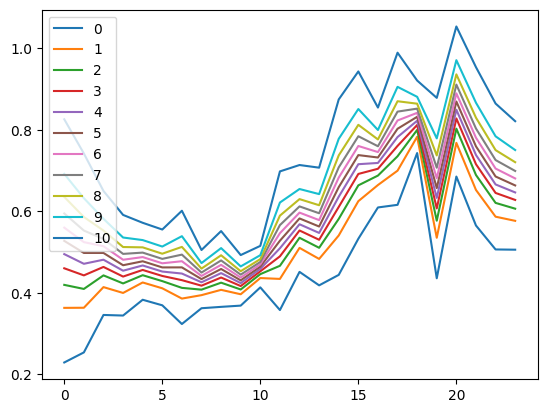

In [ ]:
# j = 1
# trial_x, trial_y = X_test[-24 * (j): -24 * (j-1)], y_test[-24 * (j): -24 * (j-1)]

test_df = test_data[-23-24-24-1:-23-24-1].drop(columns = 'time')
X_test = test_df[[col for col in test_df.columns if col != 'value']]
y_test = test_df.value
X_test = torch.from_numpy(X_test.values).to(torch.float64)
y_test = torch.from_numpy(y_test.values).to(torch.float64)

preds = model(X_test)#torch.from_numpy(X).to(torch.float64))#.shape

hourly_deviations = []
meanies = []
std_hour = X_test[:,-lookback_dim:].std(dim = 1).view(24,1)#new_df[new_df['hour'] == float(i)]['value'].std()


vals = []
for i in range(0, 11):
  q = i/10 if i not in [0,10] else (0.01 if i == 0 else 0.99)
  bias = mean_pred - mean_obs
  corrected_mean = preds - bias#(preds - mean)


  pred2 = preds +  (2 * std_hour) * torch.sqrt(torch.tensor(2)) * torch.erfinv(torch.tensor((2 * q) - 1))

  vals.append(pred2)
  plt.plot(pred2.detach().numpy(), label = str(i))

plt.legend()
plt.show()

pred = torch.concat(vals, dim = 1).detach().numpy()

# Submission Block

In [ ]:
from datetime import datetime


In [ ]:
submission = pd.DataFrame(columns = ['timestamp']+['p' + str(i*10) for i in range(11)])
submission['timestamp'] = pd.date_range(start = '2023-07-01 01:00:00',
                                         end =  '2023-07-02 00:00:00',
                                         freq='H',
                                         tz = states['tx']['local_time_zone']
                                         )
submission[['p' + str(i*10) for i in range(11)]] = pred

submission.to_csv("/content/drive/MyDrive/net_load_forecasting/submissions/tx_pytorch1_submission_{}.csv".format(datetime.now()))

upload_function(submission.set_index('timestamp'),'tx')